# Miscellaneous Molecules Calculations


In [1]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import MarksConstants as mc
from scipy.optimize import curve_fit


In [2]:
from matplotlib import gridspec
import scipy.signal
%config Completer.use_jedi = False
import numpy as np 
from numpy import array as arr
import pandas as pd
import plotly.offline as pltly
pltly.init_notebook_mode(connected=True)
from plotly import graph_objs as go
import math
import scipy.optimize as opt
from scipy import ndimage
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap
import warnings 
warnings.filterwarnings('module')
from datetime import datetime
import uncertainties.unumpy
import IPython
import pandas as pd
import pickle
from matplotlib.ticker import ScalarFormatter
from matplotlib.pyplot import *
from matplotlib import rcParams
from matplotlib import style
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
%matplotlib inline

# ## set matplotlib plot defaults :D
# Style controls many default colors in matplotlib plots.
# Change the following if you don't like dark backgrounds. Many other options.
import matplotlib as mpl

if False:
    # My Dark Settings
    style.use(['dark_background'])
    c = '#0A0A0A'
    mpl.rcParams['axes.facecolor'] = '#000000'
    mpl.rcParams['figure.edgecolor'] = c
    mpl.rcParams['figure.facecolor'] = c
else:
    # My Light Settings
    style.use(['default'])
    c = '#FFFFFF'
    mpl.rcParams['axes.facecolor'] = c
    mpl.rcParams['figure.edgecolor'] = c
    mpl.rcParams['figure.facecolor'] = c  
# the default cycling of colors in this mode isn't very good.
#rcParams['axes.prop_cycle'] = ("cycler('color', ['r','c','g','#FFFFFF','b']) + cycler('marker', ['o','v','<','>','^'])")
### General
mpl.rcParams['figure.figsize'] = (25.0, 8.0)
mpl.rcParams['axes.grid'] = True
mpl.rcParams['axes.formatter.useoffset'] = False
mpl.rcParams['grid.alpha'] = 0.15
mpl.rcParams['axes.formatter.limits'] = (-3,3)
mpl.rcParams['image.cmap'] = 'viridis'
#rcParams['image.cmap'] = dark_viridis_cmap
# to see all available options, decomment this line.
# print(mpl.rcParams)
mpl.rcParams['font.size'] = 14
viridis = cm.get_cmap('viridis', 256)
dark_viridis = []
bl = 0.15
for i in range(256):
    dark_viridis.append(list(viridis(i)))
    dark_viridis[-1][0] = dark_viridis[-1][0] *(bl+(1-bl)*i/255)
    dark_viridis[-1][1] = dark_viridis[-1][1] *(bl+(1-bl)*i/255)
    dark_viridis[-1][2] = dark_viridis[-1][2] *(bl+(1-bl)*i/255)
dark_viridis_cmap = ListedColormap(dark_viridis)
import mpl_toolkits.axes_grid1
import matplotlib.gridspec as gridspec
from skimage.transform import iradon

## Velocity of atoms for given temp 

the one-axis velocity distribution is a gaussian with waist $w_{th}=\sqrt{4k_BT/m}$

most particles will collide with velocities less than this therefore, so the waist velocity is a good benchmark.

In [4]:
T = 20e-6
v_atom = np.sqrt(4*mc.k_B * T/mc.Rb87_M)
print(v_atom, 'm/s')

0.08748412166326573 m/s


## Temperature of atom after escaping trap

In [12]:
T = .3e-6
vmin = np.sqrt(4*mc.k_B * T/(mc.Rb87_M))
print(vmin,'m/s')

0.010714572933528252 m/s


$\sigma_x(t)=\sqrt{\frac{2 E_{\mathrm{KE}}}{m} t_f^2+\sigma_x(0)^2}$

In [13]:
def E(v):
    return 1/8 * mc.Rb87_M*v**2

Eke = E(0.010714572933528252)
print(Eke,'J')

2.0709732e-30 J


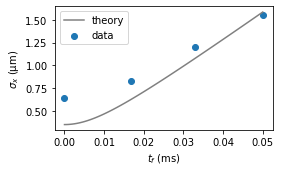

In [15]:
def sigma_x(E_KE, t_f, sigma_x_0):
    return np.sqrt((2 * E_KE/mc.Rb87_M) * t_f**2 + sigma_x_0**2)

tf = np.linspace(0,0.05e-3,100)
sigma_0 = 0.35e-6
T = 10e-6
eke = 1/2*mc.k_B*T

fig, ax = plt.subplots(figsize=(4, 2.5))
ax.plot(tf*1e3,sigma_x(eke,tf,sigma_0)*1e6,label='theory',color = 'grey')
ax.set_xlabel(r'$ t_f \ \mathrm{(ms)}$')
ax.set_ylabel(r'$ \sigma_x \ \mathrm{(\mu m)} $')

data = [(0,.64),(0.0167,0.824),(.033,1.2),(0.05,1.55)]

# Extract the x and y values into separate lists
x = [d[0] for d in data]
y = [d[1] for d in data]

# Plot the data as a scatterplot
plt.scatter(x, y,label = 'data')

# ax.set_title('expansion waist of atom in 24 uK trap')
# ax.grid(color='lightgray', linestyle='-', linewidth=0.5)
plt.legend(loc='upper left')
plt.tight_layout()


## rotational energy splittings calculation

rotational energy is given by $\frac{\hbar^2 \ell (\ell+1)}{2I}$. $I=\sum mr^2$, so for a homonuclear molecule, it's $I=2m(r/2)^2 = mr^2/2$, so $\frac{\hbar^2\ell(\ell+1)}{mr^2}$

In [17]:
def rEnergy(rv,ell):
    return mc.hbar**2*ell*(ell+1)/(mc.Rb87_M*rv**2)

molecules are generally colliding on the order of 50nm distance apart, with 10-100$\mu K$

In [18]:
rvals = np.linspace(10e-9,50e-9,100)
splittings = []
statenums = []
for rval in rvals:
    rEnergyVals = []
    for ellVal in np.arange(100):
        rEnergyVals = np.append(rEnergyVals, rEnergy(rval,ellVal)/mc.h/1e6)
    closestState = np.argmin(abs(rEnergyVals - 4))
    statenums.append(closestState)
    splittings.append(rEnergyVals[closestState+1]-rEnergyVals[closestState])

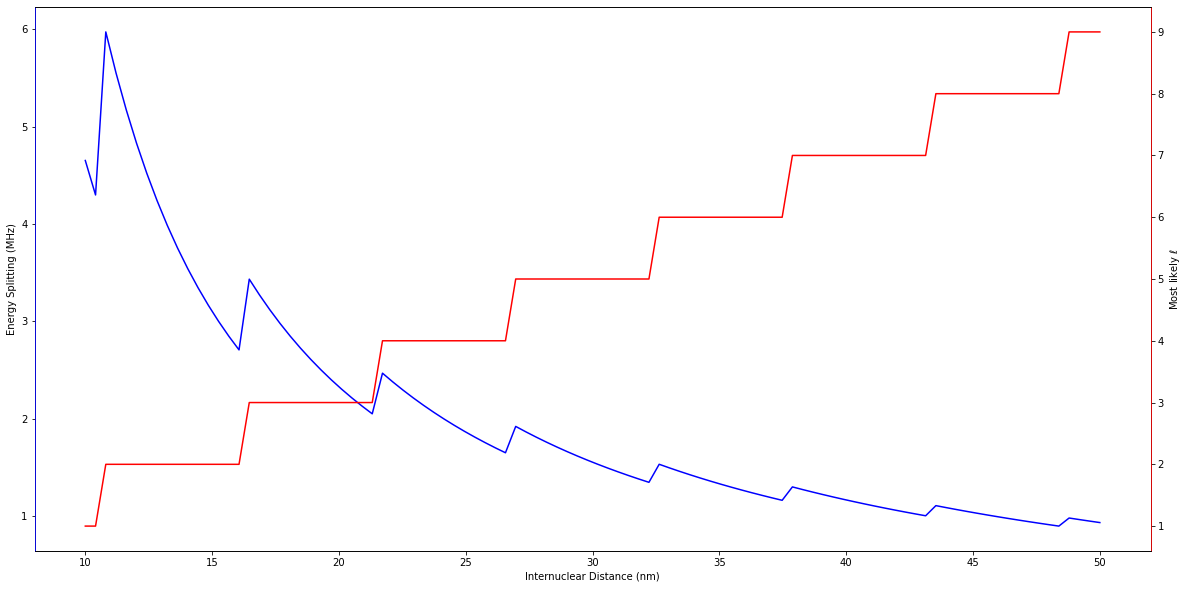

In [19]:
fig, ax = plt.subplots(figsize=(20,10))
ax.plot(rvals*1e9,splittings,'-b')
ax.set_ylabel('Energy Splitting (MHz)')
ax2 = ax.twinx()
ax2.plot(rvals*1e9, statenums,color='r')
ax2.spines['right'].set_color('r')
ax2.spines['left'].set_color('b')
ax.set_xlabel('Internuclear Distance (nm)')
ax2.set_ylabel('Most likely $\ell$')
# fig.savefig('Rotational_Energy_Separation.png', dpi=400)

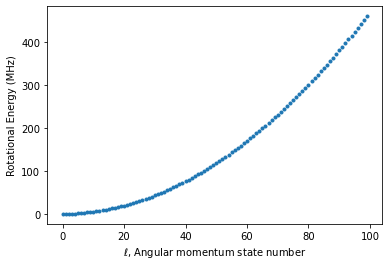

In [20]:
plt.plot( rEnergyVals,'.')
plt.ylabel( 'Rotational Energy (MHz)');
plt.xlabel( '$\ell$, Angular momentum state number');
#plt.axhline(4)
#plt.axhline(2)
#plt.axhline(0.2)


In [17]:
m = mc.Rb87_M
v = np.sqrt(2*1.32e-26/mc.Rb87_M)
vMicro = v*1e3
t = 20e-6
x = v*t
print(vMicro)
print(x)

427.70526454241264
8.554105290848253e-06


## single atom heating loss

In [26]:
# intensity on atom (units in mm)

f_col = 15.29 # focal length of collimating lens  c260=15.29    c280=18.4   
fiber_NA = 0.092 # nominal fiber numerical aperture
beam_radius = f_col*fiber_NA/10
beam_radius # collimated beam radius
beam_power = 2.500 # mW
intensity = beam_power/(np.pi*beam_radius**2)
print("intensity =",intensity*10, "mW/cm^2")

intensity = 402.1605910175146 mW/cm^2


In [27]:
# constants
photonEnergyEv = 1.559 # transition energy in ev - Steck
photonEnergeJoules = photonEnergyEv/6.242e18
KelvinToEv = 8.61732814974493E-05
KelvinToJoules = 1.380648780669e-23
lifetime = 27.7e-9 # s to p d1 lifetime (s)

# parameters
survivalDecay = 1 # per ms
pulseLength = 1/survivalDecay # ms
cyclesPerPulse = pulseLength*1e-3/lifetime # s
initialAtomTemp = 4e-6 # K
trapDepth = 24e-6 # K
deltaT = trapDepth-initialAtomTemp # K
tempGainPerCycle = deltaT/cyclesPerPulse #K
energyGainPerCycle = tempGainPerCycle*KelvinToEv
totalEnergyReleased = cyclesPerPulse*photonEnergyEv
fractionGained = energyGainPerCycle/totalEnergyReleased
k_L = 795e-9/(2*np.pi)

print('pulse length for single atom loss = ', pulseLength,'ms')
print('cycles Per Pulse =',cyclesPerPulse)
print('temp increase per cycle = ', tempGainPerCycle,'K')
print('energy increase per cycle  =',energyGainPerCycle, 'eV')
print('fraction of E_tot  =',fractionGained)

pulse length for single atom loss =  1.0 ms
cycles Per Pulse = 36101.08303249098
temp increase per cycle =  5.54e-10 K
energy increase per cycle  = 4.7739997949586917e-14 eV
fraction of E_tot  = 8.482347294442319e-19


## phonon number and atom temp calculation

average phonon number: $ \ \ \ \bar{n}=\frac{1}{\exp \left(\frac{\hbar \omega_r}{k_b T}\right)-1} $

Atom temperature:$ \ \ \ \ T =  \frac{\hbar \omega_r}{k_b} \mathrm{ln} \left(\frac{1}{\bar{n}} +1\right)^{-1}$

radial trap frequency: $ \ \ \ \ \ \omega_r=\left(\frac{4 U}{m w_0^2}\right)^{1 / 2} \ \  \ \ \ \omega_0 = 700 \  \mathrm{nm} \ \ \ $ (tweezer waist)

$ T = 15 \  \mathrm{\mu K}$ when $U = 1  \ \mathrm{mK}$  <br>


$\rightarrow \bar{n} = 1.76$

At 24 $\mathrm{\mu K}, \ \ \  T = 2.32 \  \mathrm{\mu K} $ 

In [28]:
def atom_temp(trap_depth):
    KelvinToJoules = 1.380648780669e-23
    w_0 = 0.7e-6 # beam waist (radius)
    T_1mK = 15e-6 # atom temp in 1 mK trap
    U = trap_depth*KelvinToJoules # depth in Joules
    U_1mK = 1e-3*KelvinToJoules # depth in Joules
    wr_1mK = np.sqrt(4*U_1mK/(mc.Rb87_M*w_0**2)) # Hz
    w_r = np.sqrt(4*U/(mc.Rb87_M*w_0**2)) # Hz
    nbar = 1/(np.exp(mc.hbar*wr_1mK/(mc.k_B*T_1mK))-1)
    T = mc.hbar*w_r/mc.k_B *1/(np.log(1/nbar+1))
    print('T =',T,'radial trap freq = ',w_r/(2*np.pi)) 
    

In [30]:
atom_temp(1e-3)

T = 1.5e-05 radial trap freq =  140648.89569055918


In [153]:
T_1mK = 15e-6 # atom temp in 1 mK trap
U_1mK = 1.2e-3*KelvinToJoules # 
U_11uK = 11e-6*KelvinToJoules # K (TOF depth)
U_halfmK = 0.5e-3*KelvinToJoules # K (TOF depth)
U_1point12mK = 1.12e-3*KelvinToJoules # K (TOF depth)
w_0 = 0.7e-6 # beam waist (radius)
wr_11uK = np.sqrt(4*U_11uK/(mc.Rb87_M*w_0**2)) # Hz
wr_1mK = np.sqrt(4*U_1mK/(mc.Rb87_M*w_0**2)) # Hz
wa_1mK = np.sqrt(2*U_1mK/(mc.Rb87_M*w_0**2)) # Hz
print('trap freq at 0.85 mK (Hz):',wr_1mK/(2*np.pi))


trap freq at 0.85 mK (Hz): 154073.14571582078 108946.16613439994


In [62]:
nbar = 1/(np.exp(mc.hbar*wr_1mK/(mc.k_B*T_1mK))-1)
nbar2 = 1/(np.exp(mc.hbar*(wa_1mK/2*np.pi)/(mc.k_B*T_1mK))-1)
print('nbar axial = ',nbar1)

NameError: name 'nbar1' is not defined

In [9]:
ray = np.pi*w_0**2/(850e-9)
wa_1mK = np.sqrt(2*U_1mK/(mc.Rb87_M*ray**2))
print(wa_1mK/(2*np.pi))

38440.7933191914


In [61]:
wr_11uK = np.sqrt(4*U_11uK/(mc.Rb87_M*w_0**2)) # Hz
wr_halfmK = np.sqrt(4*U_halfmK/(mc.Rb87_M*w_0**2)) # Hz
wr_1point12mK = np.sqrt(4*U_1point12mK/(mc.Rb87_M*w_0**2)) # Hz
T_11uK = mc.hbar*wr_11uK/mc.k_B *1/(np.log(1/nbar+1))
T_halfmK = mc.hbar*wr_halfmK/mc.k_B *1/(np.log(1/nbar+1))
T_1point12mK = mc.hbar*wr_1point12mK/mc.k_B *1/(np.log(1/nbar+1))
print('temperature at 24 uK =',T_24uK)
print('temperature at 0.5 mK =',T_halfmK)
print('temperature at 1.12 mK =',T_1point12mK)

temperature at 24 uK = 1.2624381172952598e-05
temperature at 0.5 mK = 9.682458365518545e-06
temperature at 1.12 mK = 1.449137674618944e-05


In [21]:
lmbda = 850e-9
k = 2*np.pi/ lmbda
delta_k =k/np.sqrt(2)
x_0_r = (mc.hbar/(2*mc.Rb87_M*wr_1mK))**(1/2)
x_0_a = (mc.hbar/(2*mc.Rb87_M*wa_1mK))**(1/2)
eta_r = delta_k*x_0_r
eta_a = delta_k*x_0_a
print('Lamb-Dicke radial',eta_r)
print('Lamb-Dicke axial',eta_a)


Lamb-Dicke radial 0.10628049234296305
Lamb-Dicke axial 0.20329446291506392


## kinetic energy release in light assisted collisions

This model treats the collisions in one dimension by fixing one atom in space and solving for the motion of the other atom as it experiences the repulsive potential from the resonant dipole interaction. 

$\begin{aligned}
& T=\frac{1}{2} m \dot{r}^2 \quad U=-\frac{C_3}{r^3} \\
\\
& \mathcal{L}=\frac{1}{2} m \dot{r}^2+\frac{C_3}{r^3} \\
\\
& \frac{d}{d t}\left(\frac{\partial \mathcal{L}}{\partial \dot{r}}\right)-\frac{\partial \mathcal{L}}{\partial r}=0 \\
\\
& \rightarrow \quad \ddot{r}=\frac{3 C_3}{mr^4} \\
&
\end{aligned}$

Solving this and plotting $r(t)$ and  $\dot{r}(t)$ with an initial conditions of $r(0) = 50 \ \mathrm{nm}$ and $\dot{r}(0)=-0.087 \  \mathrm{m/s}$ gives

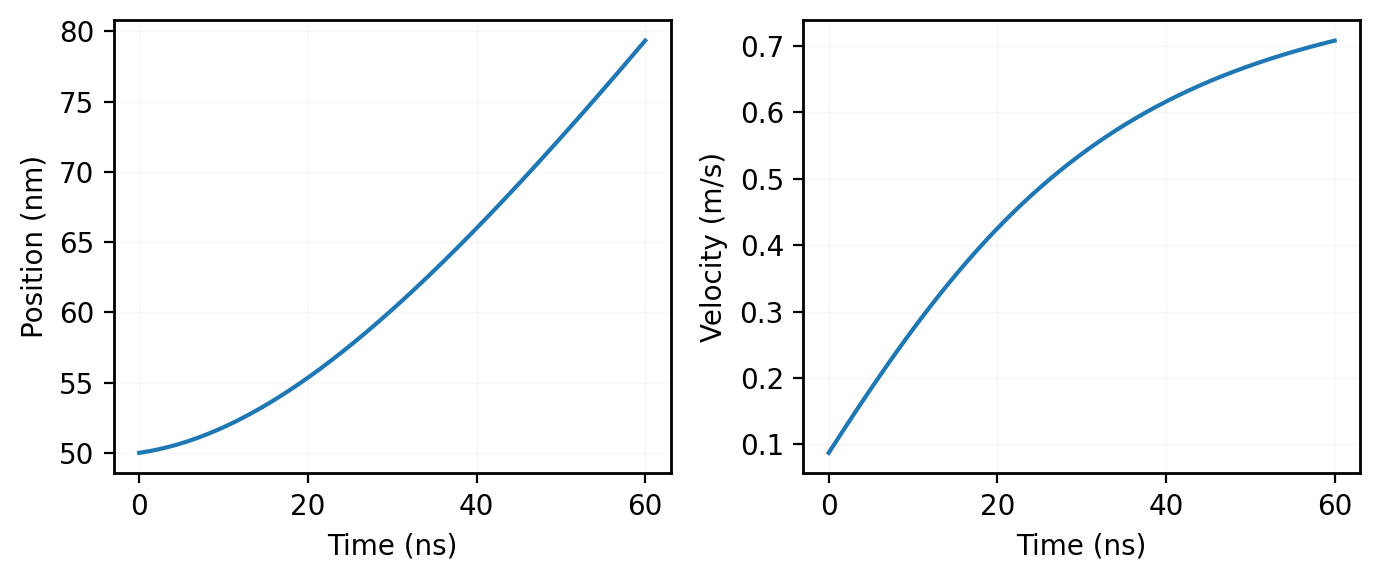

In [49]:
m = mc.Rb87_M
C3 = mc.Rb87_C3

# Define the differential equation
def diff_eq(t, r):
    drdt = np.zeros(2)
    drdt[0] = r[1]
    drdt[1] = 3*C3/(m*r[0]**4)
    # dydt[1] = 3*c/(y[0]**4)
    return drdt

# Define initial conditions
r0 = [50e-9, 0.087]

# Define time span for which to solve the differential equation
t_span = [0, 60e-9]
times = np.linspace(0,60e-9,1000)

# Solve the differential equation
sol = solve_ivp(diff_eq, t_span, r0,t_eval=times)

# Plot the solution
fig, axs = plt.subplots(1, 2, figsize=(7, 3))

axs[0].plot(sol.t*1e9, sol.y[0]*1e9)
axs[0].set_xlabel('Time (ns)')
axs[0].set_ylabel('Position (nm)')
axs[0].grid(color='lightgray', linestyle='-', linewidth=0.5)
axs[1].plot(sol.t*1e9, sol.y[1])
axs[1].set_xlabel('Time (ns)')
axs[1].set_ylabel('Velocity (m/s)')

plt.rcParams['font.size'] = 10
plt.rcParams["axes.edgecolor"] = "black"
plt.rcParams["axes.linewidth"] = 1.0    
plt.rcParams['figure.dpi'] = 200
plt.grid(color='lightgray', linestyle='-', linewidth=0.5)
plt.tight_layout()
plt.show()


For an excited state lifetime of $27.7 \ \mathrm{ns}$, the atoms gain kinetic energy proportional to $v= 0.087 \ \mathrm{m/s}$.

Using $v=\sqrt{4k_BT/m}$, and $E = \frac{3}{2} k_b T$, we get 

$T = \frac{mv^2}{4 k_b} \ \ \ \rightarrow \ \ \ \ E= \frac{3}{8}mv^2$

In [50]:
# convert velocity to energy in MHz
mK_to_MHz = 20.83661763613 
def E(v):
    E_Mhz = 1/8 * mc.Rb87_M*v**2/mc.h*1e-6
    E_mK = E_Mhz/mK_to_MHz
    return E_Mhz,E_mK

print(E(.5)[0], 'MHz',E(.4)[1]*1e3,'uK')

6.806263164058977 MHz 209.05544753312418 uK


In MHz, this gives $E = 17.5$ MHz which is pretty close to the trap depth 20 MHz. Since this is the total energy it is shared evenly between each atom which would suggest about LAC 2 cycles are needed to kick an atom out. According to the estimated 2-1 rate of 0.2/ms, this would suggest the 2-1 collisions saturate around 10 ms which is roughly what we see.

A plot of energy release in MHz as a function of the final velocity and the detuning is shown below.

In [21]:
trap_freq = 1e5
period = 2*np.pi/trap_freq
length = np.sqrt(mc.hbar/(mc.Rb87_M* trap_freq))
print('period = ',period*1e6, 'us')
print('length =',length*1e9, 'nm')
nm_to_bohr = 18.89
lengthBohr = length*1e9*nm_to_bohr
print('length in Bohr = ',lengthBohr)

period =  62.831853071795855 us
length = 85.48318756746143 nm
length in Bohr =  1614.7774131493463


[1.56816303e+02 5.33611032e+01 1.74240337e+01 6.80626316e+00
 1.70156579e+00 6.96961348e-01 6.80626316e-02 2.72250527e-05]
Fitted parameters: [ 6.09348211e+07  3.77681771e+00 -3.48410876e+00]


/var/folders/p1/sslzk5t517d2pwp06md4xf_w0000gn/T/ipykernel_1150/3893313650.py:13: RuntimeWarning:

divide by zero encountered in divide



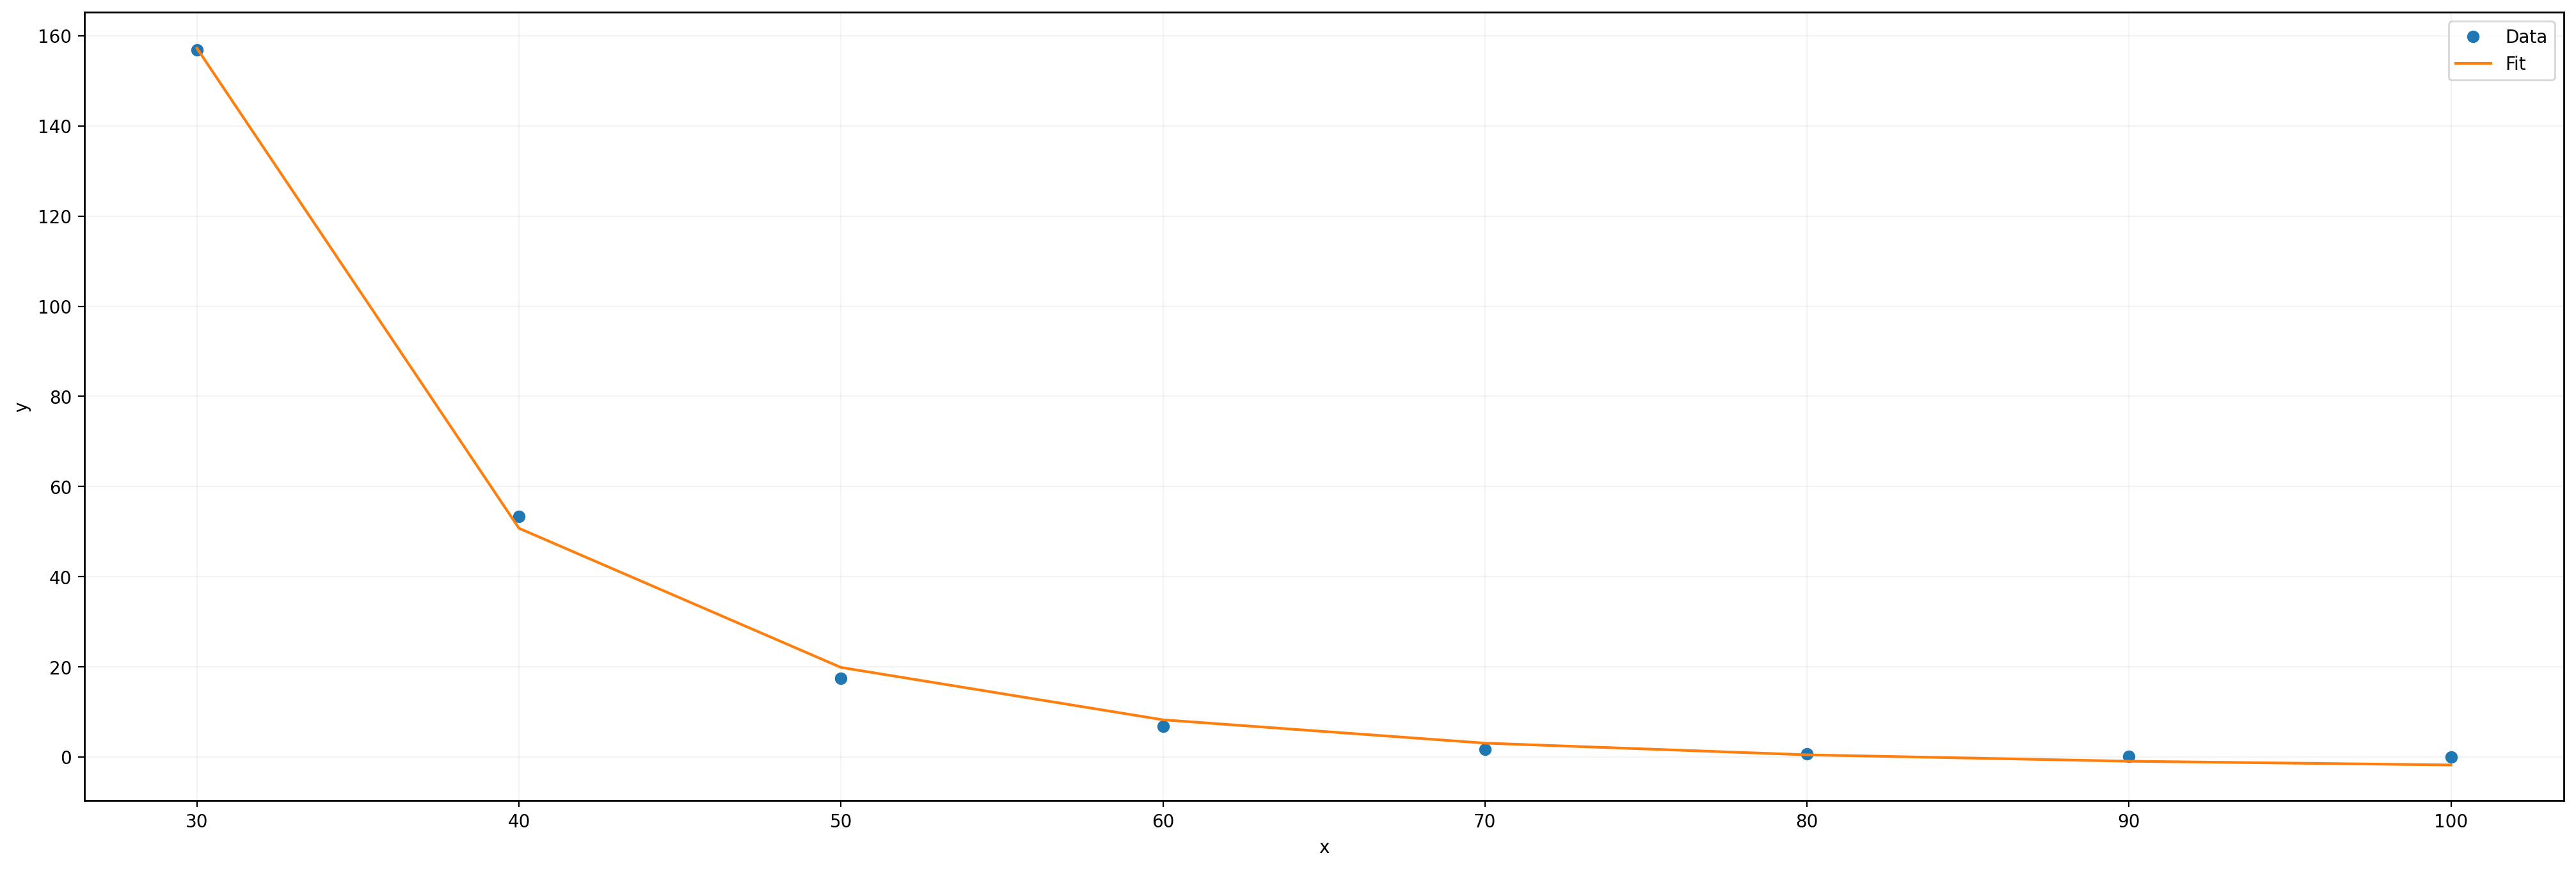

In [6]:
v = np.array([2.4,1.4,.8,.5,.25,0.16,0.05,0.001])
rc = np.array([30,40,50,60,70,80,90,100])
detuning = np.array([30,40,50,60,70,80,90,100])
vlist=[2.4,1.4,.8,.5,.25,0.16,0.05,0.001]
energies=[]
for i in vlist:
    en = E(i)[0]
    energies.append(en)
ener = np.array(energies)

# Fit the data to the function
def rcVsV(x, a,b,c):
    return a/x**b +c

ydata = ener
xdata = rc
print(ener)
popt, pcov = curve_fit(rcVsV, xdata, ydata)

print('Fitted parameters:', popt)

# Plot the data and the fitted function
plt.plot(xdata, ydata, 'o', label='Data')
plt.plot(xdata, rcVsV(xdata, *popt), '-', label='Fit')
plt.xlabel('x')
plt.ylabel('y')
# plt.xlim(10,80)
# plt.ylim(0,10)
plt.legend()
plt.show()


Fitted parameters: [ 0.1052397   1.41456381 -2.48293784]


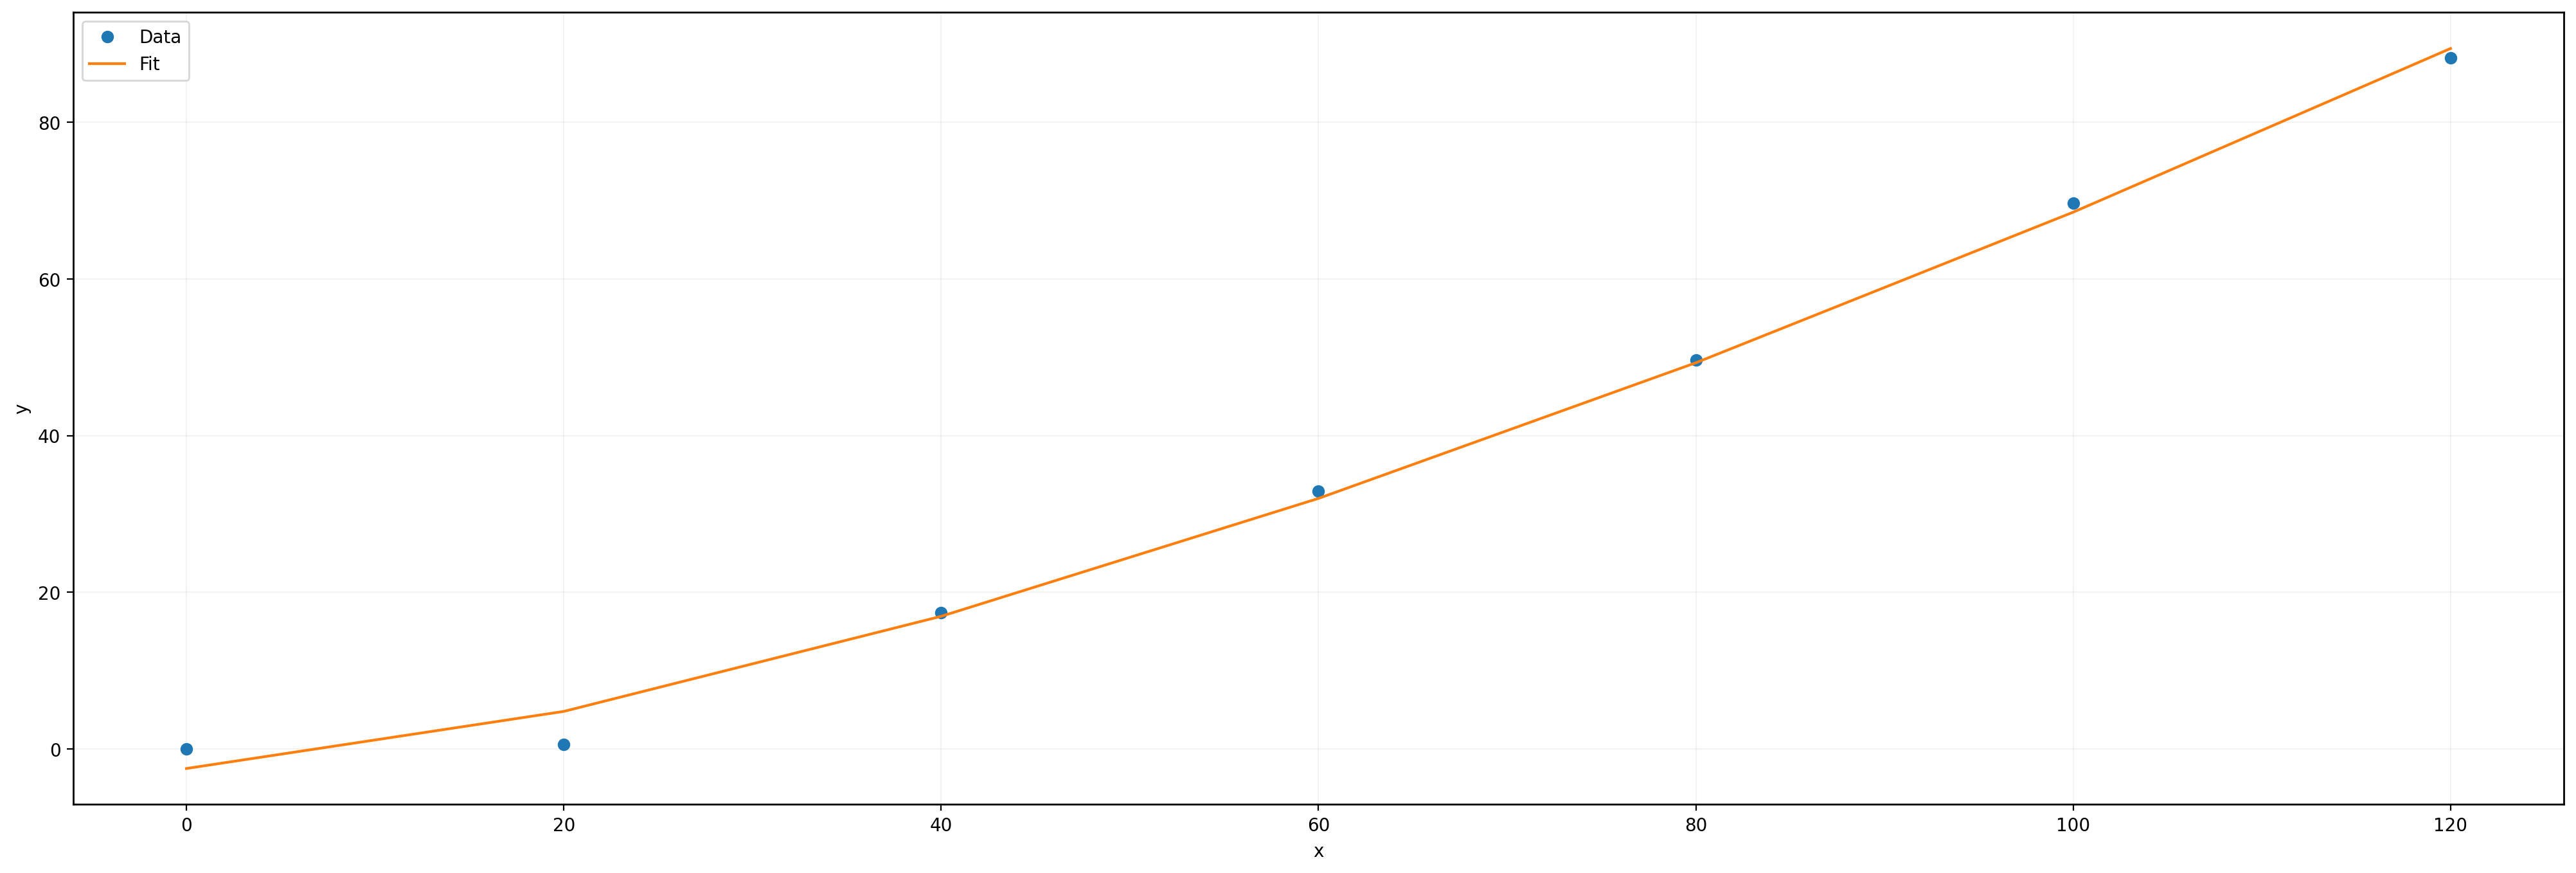

In [7]:
v_inc = np.array([0.0,0.15,0.8,1.1,1.35,1.6,1.8])
detuning = np.array([0,20,40,60,80,100,120])
vlist=[0.0,0.15,0.8,1.1,1.35,1.6,1.8]
energies=[]
for i in vlist:
    en = E(i)[0]
    energies.append(en)
ener = np.array(energies)

# Fit the data to the function
def rcVsV(x, a,b,c):
    return a*x**b +c

ydata = ener
xdata = detuning

popt, pcov = curve_fit(rcVsV, xdata, ydata)

print('Fitted parameters:', popt)

# Plot the data and the fitted function
plt.plot(xdata, ydata, 'o', label='Data')
plt.plot(xdata, rcVsV(xdata, *popt), '-', label='Fit')
plt.xlabel('x')
plt.ylabel('y')
# plt.xlim(10,80)
# plt.ylim(0,10)
plt.legend()
plt.show()


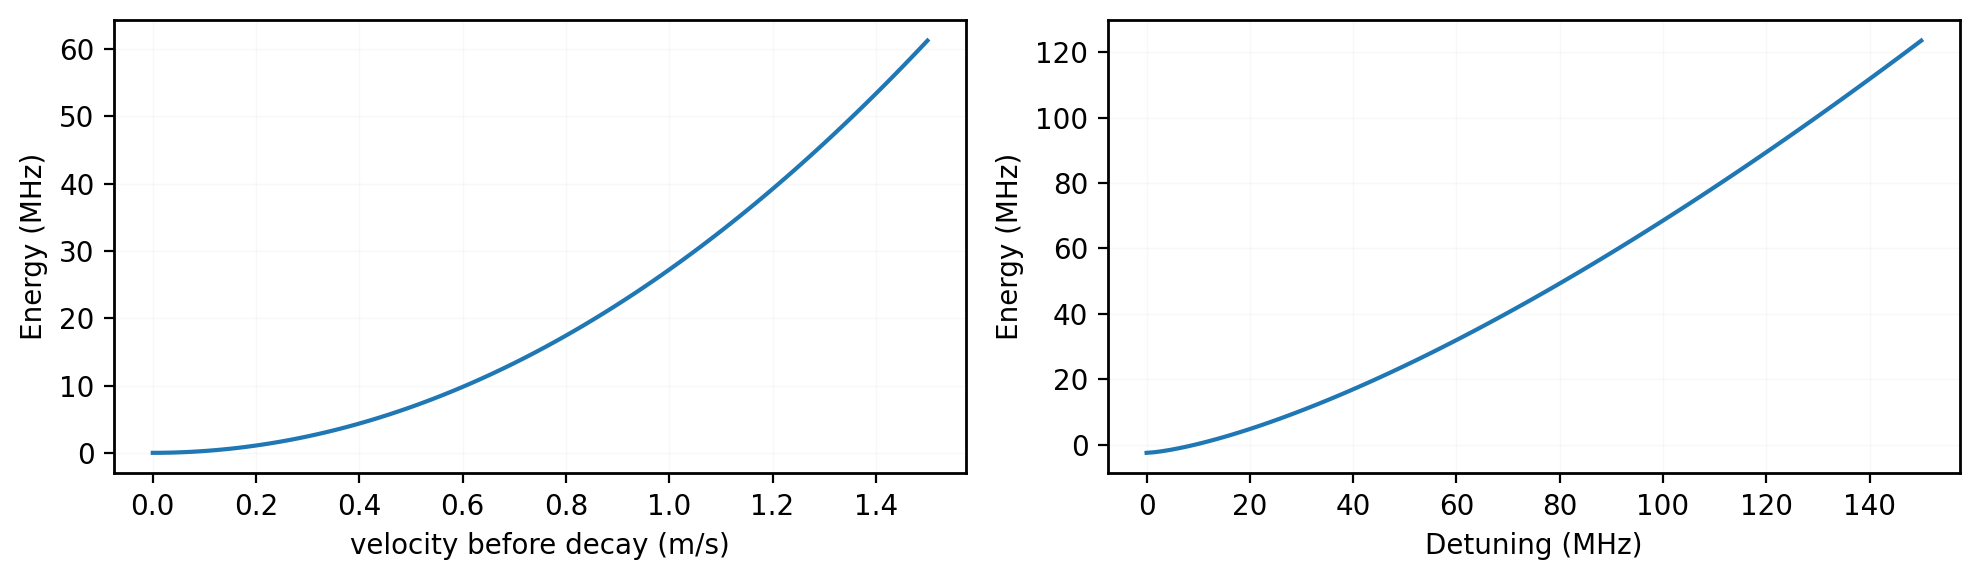

In [12]:

# create function using fit parameters for 
def rcVsV(x, a,b,c):
    return a*x**b +c

x1 = np.linspace(0,1.5,100)
x2 = np.linspace(0,150,100)
fig, axs = plt.subplots(1, 2, figsize=(10, 3))
axs[0].plot(x1, E(x1)[0])
axs[0].set_xlabel('velocity before decay (m/s)')
axs[0].set_ylabel('Energy (MHz)')
axs[0].grid(color='lightgray', linestyle='-', linewidth=0.5)
axs[1].plot(x2,rcVsV(x2, 0.1052397 ,1.41456381,-2.48293784))
axs[1].grid(color='lightgray', linestyle='-', linewidth=0.5)
axs[1].set_xlabel('Detuning (MHz)')
axs[1].set_ylabel('Energy (MHz)');
plt.tight_layout()


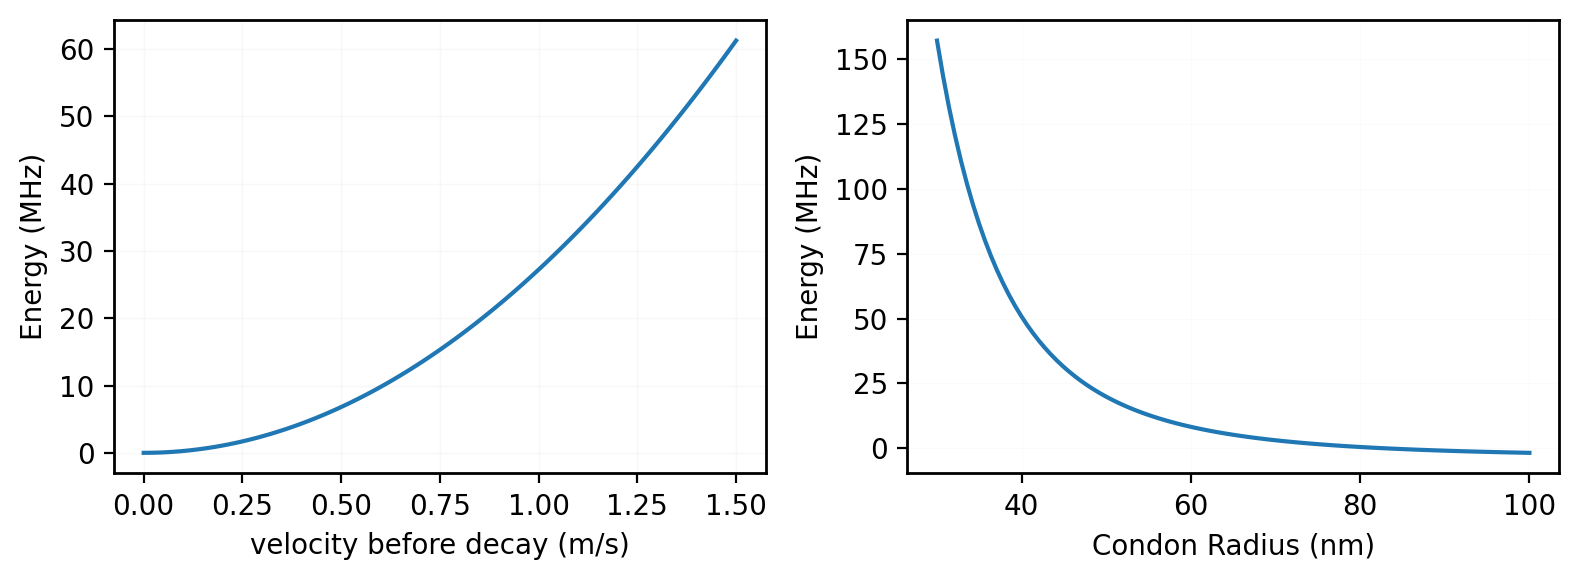

In [13]:
# convert velocity to energy in MHz
def E(v):
    return 1/8 * mc.Rb87_M*v**2/mc.h*1e-6

# create function using fit parameters for 
def rcVsV(x, a,b,c):
    return a/x**b +c

x1 = np.linspace(0,1.5,100)
x2 = np.linspace(30,100,100)
fig, axs = plt.subplots(1, 2, figsize=(8, 3))
axs[0].plot(x1, E(x1))
axs[0].set_xlabel('velocity before decay (m/s)')
axs[0].set_ylabel('Energy (MHz)')
axs[0].grid(color='lightgray', linestyle='-', linewidth=0.5)
axs[1].plot(x2,rcVsV(x2, 6.09348211e+07  ,3.77681771e+00,-3.48410876e+00))
axs[1].grid(color='lightgray', linestyle='-', linewidth=0.2)
axs[1].set_xlabel('Condon Radius (nm)')
axs[1].set_ylabel('Energy (MHz)');
plt.tight_layout()


# plt.rcParams['font.size'] = 10
# plt.rcParams["axes.edgecolor"] = "black"
# plt.rcParams["axes.linewidth"] = 1.0    
# plt.rcParams['figure.dpi'] = 200
# plt.grid(color='lightgray', linestyle='-', linewidth=0.5)
# plt.tight_layout()
# plt.show()


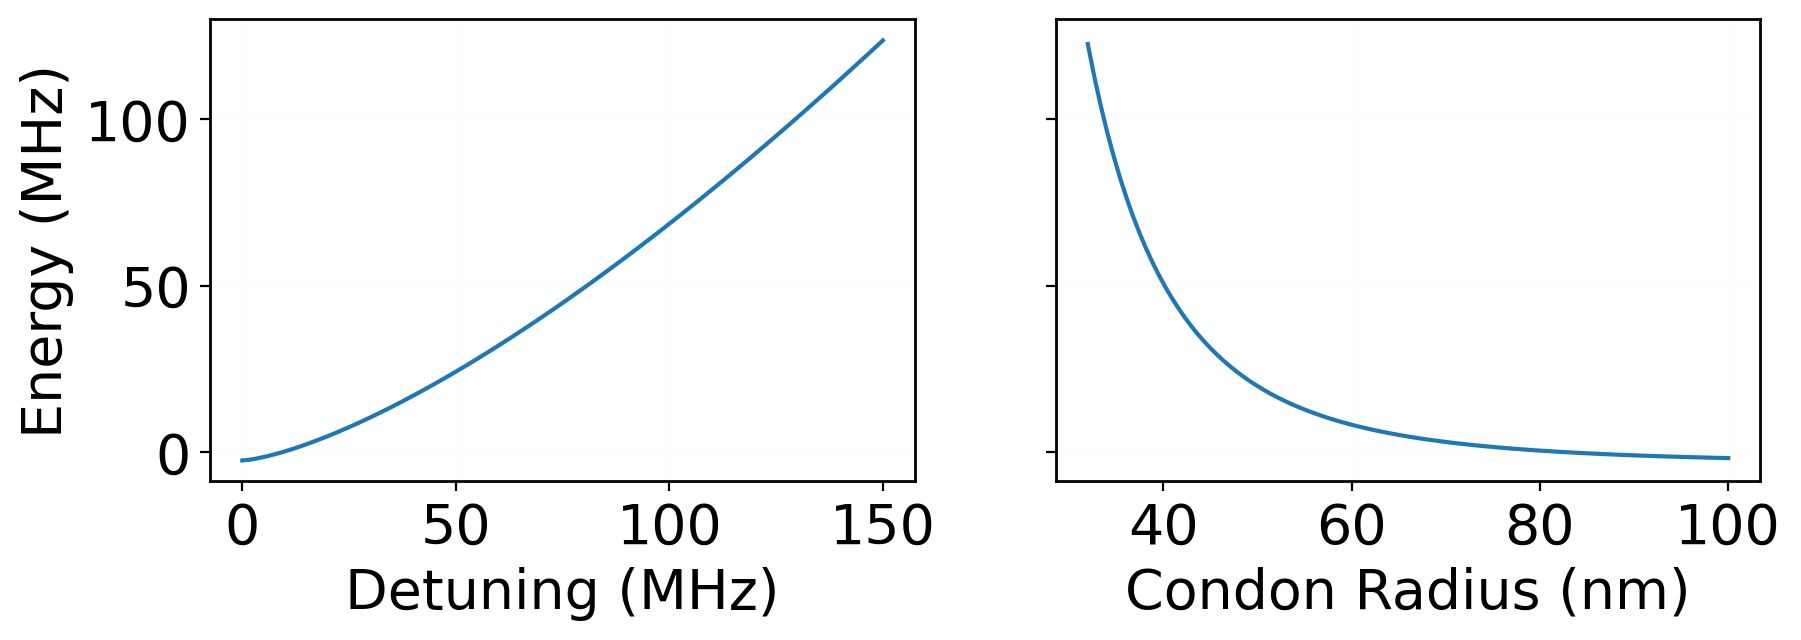

In [15]:
def rcVsVD(x, a,b,c):
    return a*x**b +c

# create function using fit parameters for 
def rcVsVR(x, a,b,c):
    return a/x**b +c


x1 = np.linspace(0,150,100)
x2 = np.linspace(32,100,100)
fig, axs = plt.subplots(1, 2, figsize=(10, 3),sharey=True)
axs[0].plot(x1,rcVsVD(x1, 0.1052397 ,1.41456381,-2.48293784))
axs[0].set_xlabel('Detuning (MHz)')
axs[0].set_ylabel('Energy (MHz)')
axs[0].grid(color='lightgray', linestyle='-', linewidth=0.2)
axs[1].plot(x2,rcVsVR(x2, 6.09348211e+07  ,3.77681771e+00,-3.48410876e+00))
axs[1].grid(color='lightgray', linestyle='-', linewidth=0.2)
axs[1].set_xlabel('Condon Radius (nm)')
# axs[1].set_ylabel('Energy (MHz)');

plt.rcParams['font.size'] = 20
# plt.savefig('class_mod.png', dpi=1200,bbox_inches="tight")

ValueError: x and y must have same first dimension, but have shapes (100,) and (5,)

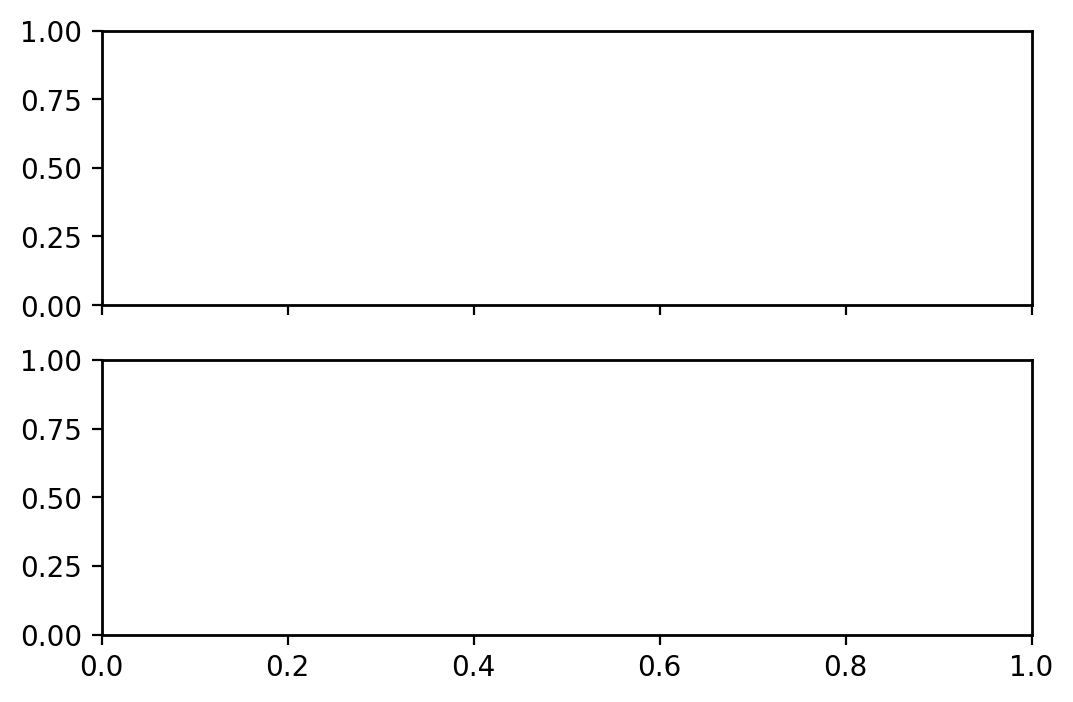

In [26]:
# Create a figure and two subplots
fig, ax = plt.subplots(2, 1, sharex=True)

# Plot data on the first subplot
ax[0].plot(x1, y1, label='Plot 1')
ax[0].set_ylabel('Y-axis for Plot 1')

# Plot data on the second subplot
ax[1].plot(x2, y2, label='Plot 2')
ax[1].set_ylabel('Y-axis for Plot 2')
ax[1].set_xlabel('X-axis')

# Customize the appearance of the plots
ax[0].legend()
ax[1].legend()

# Adjust the spacing between subplots
plt.subplots_adjust(hspace=0.3)

# Show the plots
plt.show()

## Monte Carlo

In [251]:
import numpy as np
import matplotlib.pyplot as plt

# Set up simulation parameters
n_steps = 10  # number of simulation steps
delta_vals = np.linspace(-10, 10, 101)  # array of detuning values to simulate
a = 0.5  # oscillator length
k = 1.0  # spring constant
m = 1.0  # mass of atoms
hbar = 1.0  # Planck's constant divided by 2 pi
sigma = 0.1  # standard deviation of velocity distribution

# Define the Hamiltonian
def hamiltonian(delta):
    return np.array([[hbar * delta, k / 2], [k / 2, -hbar * delta]])

# Define the Monte Carlo simulation
def monte_carlo_sim(delta):
    x = np.random.normal(0, sigma, 2)
    p = np.random.normal(0, sigma, 2)
    h = hamiltonian(delta)
    for i in range(n_steps):
        # Calculate time step
        dt = np.random.exponential(1 / (2 * np.sqrt(k / m)))
        # Update positions and momenta
        x = x + p * dt / m
        p = p - dt * k * x - 1j * dt * h @ p / hbar
        x = x + p * dt / m
        # Check for inelastic collision
        if np.linalg.norm(x) > a:
            return False
    return True

# Perform the simulation for each detuning value and calculate the probability of inelastic collision
prob_inelastic = []
for delta in delta_vals:
    n_inelastic = 0
    for i in range(1000):
        if not monte_carlo_sim(delta):
            n_inelastic += 1
    prob_inelastic.append(n_inelastic / 1000)


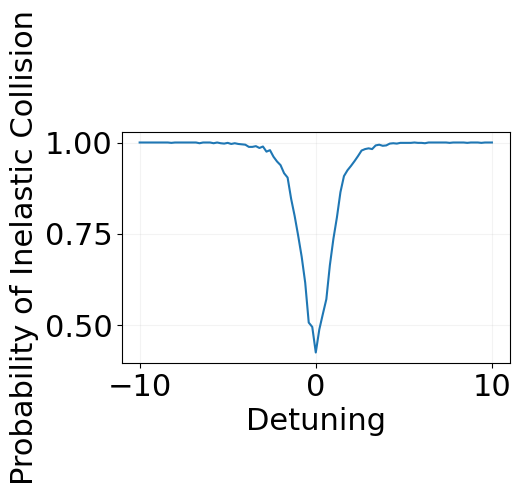

In [252]:
# Plot the probability of inelastic collision as a function of detuning
plt.figure(figsize=(5,3))
plt.plot(delta_vals, prob_inelastic)
plt.xlabel('Detuning')
plt.ylabel('Probability of Inelastic Collision')
plt.show()

In [87]:
import numpy as np
import matplotlib.pyplot as plt

# Set up simulation parameters
n_steps = 10  # number of simulation steps
delta = 1.0  # detuning
a = 0.5  # oscillator length
k = 1.0  # spring constant
m = 1.0  # mass of atoms
hbar = 1.0  # Planck's constant divided by 2 pi
sigma = 0.1  # standard deviation of velocity distribution
pulse_durations = np.linspace(0.1, 10, 100)  # pulse durations to simulate

# Define the Hamiltonian
def hamiltonian(delta):
    return np.array([[hbar * delta, k / 2], [k / 2, -hbar * delta]])

# Define the Monte Carlo simulation
def monte_carlo_sim(tau):
    x = np.random.normal(0, sigma, 2)
    p = np.random.normal(0, sigma, 2)
    h = hamiltonian(delta)
    dt = tau / n_steps
    for i in range(n_steps):
        # Update positions and momenta
        x = x + p * dt / m
        p = p - dt * k * x - 1j * dt * h @ p / hbar
        x = x + p * dt / m
        # Check for inelastic collision
        if np.linalg.norm(x) > a:
            return False
    return True

# Perform the simulation for each pulse duration and calculate the probability of inelastic collision
prob_inelastic = []
for tau in pulse_durations:
    n_inelastic = 0
    for i in range(1000):
        if not monte_carlo_sim(tau):
            n_inelastic += 1
    prob_inelastic.append(n_inelastic / 1000)


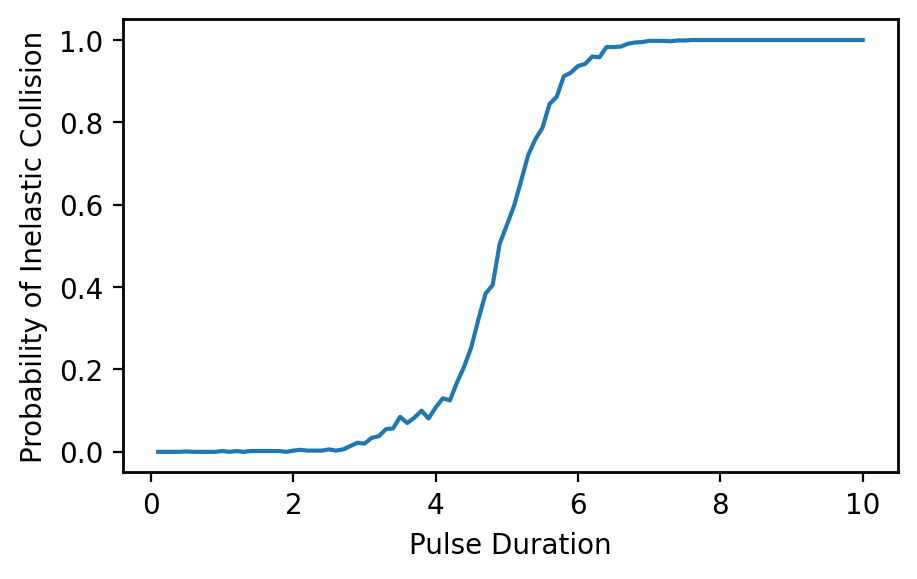

In [88]:
# Plot the probability of inelastic collision as a function of pulse duration
plt.figure(figsize=(5,3))
plt.plot(pulse_durations, prob_inelastic)
plt.xlabel('Pulse Duration')
plt.ylabel('Probability of Inelastic Collision')
plt.show()

## Landau-Zener Model

The probability for a single LZ transition is given by $P_{L Z}=\exp \left(\frac{-2 \pi \Omega^2}{3 v \Delta}\left(\frac{C_3}{\hbar \Delta}\right)^{1 / 3}\right)$

The probability for a single adiabatic following is $P_{A}=1-P_{L Z}$

A repulsive inelastic collision is defined by a LZ transition followed by an adiabatic transition or vice verse. 


Therefore the inelastic collision probability is 

$P_{IR}=2 P_{L Z} P_A=2 P_{L Z}\left(1-P_{L Z}\right)$

For an attractive potential, the inelastic collision probability is 

$P_{I A}=P_A+\frac{P_{L Z}^2 P_A}{1-P_A^2}=1-\frac{P_{L Z}}{2-P_{L Z}}$

The generalized Rabi rate is $\Omega_{eff} =\sqrt{\Omega^2+\delta^2}$ where $\Omega =\frac{d E}{ \hbar}$ and $I= \frac{1}{2}c \epsilon_{0} E^2$

Steck gives $d = 2.537 \times 10^{-29} \ C \cdot m $  for D1 and $d = 3.584 \times 10^{-29} \ C \cdot m $ for D2

Using saturation intenisites for D1 and D2 :

$I_{D1} = 4.484 \frac{mW}{cm^2} = 44.84 \frac{W}{m^2}$ and $I_{D2} = 2.503 \frac{mW}{cm^2} = 25.03 \frac{W}{m^2}$ 

In [35]:
def atomVelocity(T):
    v = np.sqrt(4*mc.k_B * T/mc.Rb87_M) 
    return v

In [36]:
def rabiRate(mu,I): # I is in mW/cm^2
    omega = (mu/mc.hbar)*np.sqrt(2*I/(mc.c*mc.epsilon0))
    return omega

In [37]:
def rabiRateGen(mu,I,delta): # I is in mW/cm^2
    omega = (mu/mc.hbar)*np.sqrt(2*I/(mc.c*mc.epsilon0))
    rabi_gen = np.sqrt(omega**2+(delta*1e6)**2)
    return rabi_gen

In [38]:
def P_inelastic_red(T,I,mu,delta):
    v = atomVelocity(T)
    Omega = rabiRate(mu,I)
    PLZ = np.exp((-2 * np.pi * Omega**2) / (3 * v * delta*1e6) * ((mc.Rb87_C3 / (mc.hbar * delta*1e6))**(1 / 3))) 
    P_in = 1-PLZ/(2-PLZ)
    return P_in

In [39]:
def P_inelastic_blue(T,I,mu,delta):
    v = atomVelocity(T)
    Omega = rabiRate(mu,I)
    PLZ = np.exp((-2 * np.pi * Omega**2) / (3 * v * delta*1e6) * ((mc.Rb87_C3 / (mc.hbar * delta*1e6))**(1 / 3))) 
    P_in = 2*PLZ*(1-PLZ)
    return P_in

In [17]:
rabiRate(muD1,IsatD1*10)*1e-6

44.21884547655938

### Rabi Rate vs Detuning 

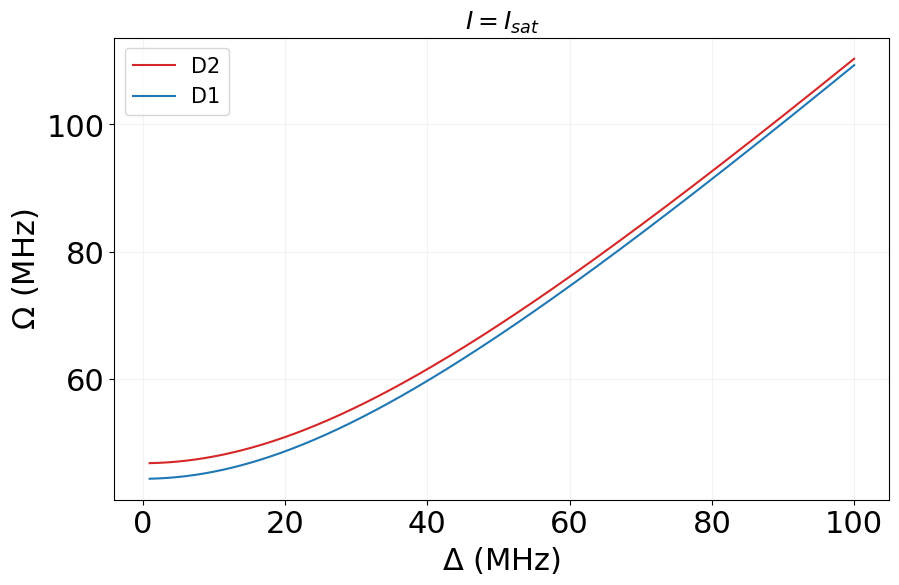

In [33]:
fig, ax = plt.subplots(figsize=(10, 6))
font = {'family' : 'DejaVu Sans',
        'weight' : 'normal',
        'size'   : 22}
matplotlib.rc('font', **font)
delta = np.linspace(1,100,1000)
IsatD1 = 4.484
IsatD2 = 2.503
muD1=2.537e-29
muD2=3.584e-29
ax.plot(delta,rabiRateGen(muD2,IsatD2*10,delta)*1e-6, color = 'tab:red',label = 'D2')
ax.plot(delta,rabiRateGen(muD1,IsatD1*10,delta)*1e-6, color = 'tab:blue',label = 'D1')
plt.xlabel(r'$\Delta $ (MHz)')
plt.ylabel(r'$\Omega$ (MHz)');
plt.legend(fontsize=15)
plt.title(r'$I=I_{sat}$',fontsize=18);

### Inelastic Prob vs detuning

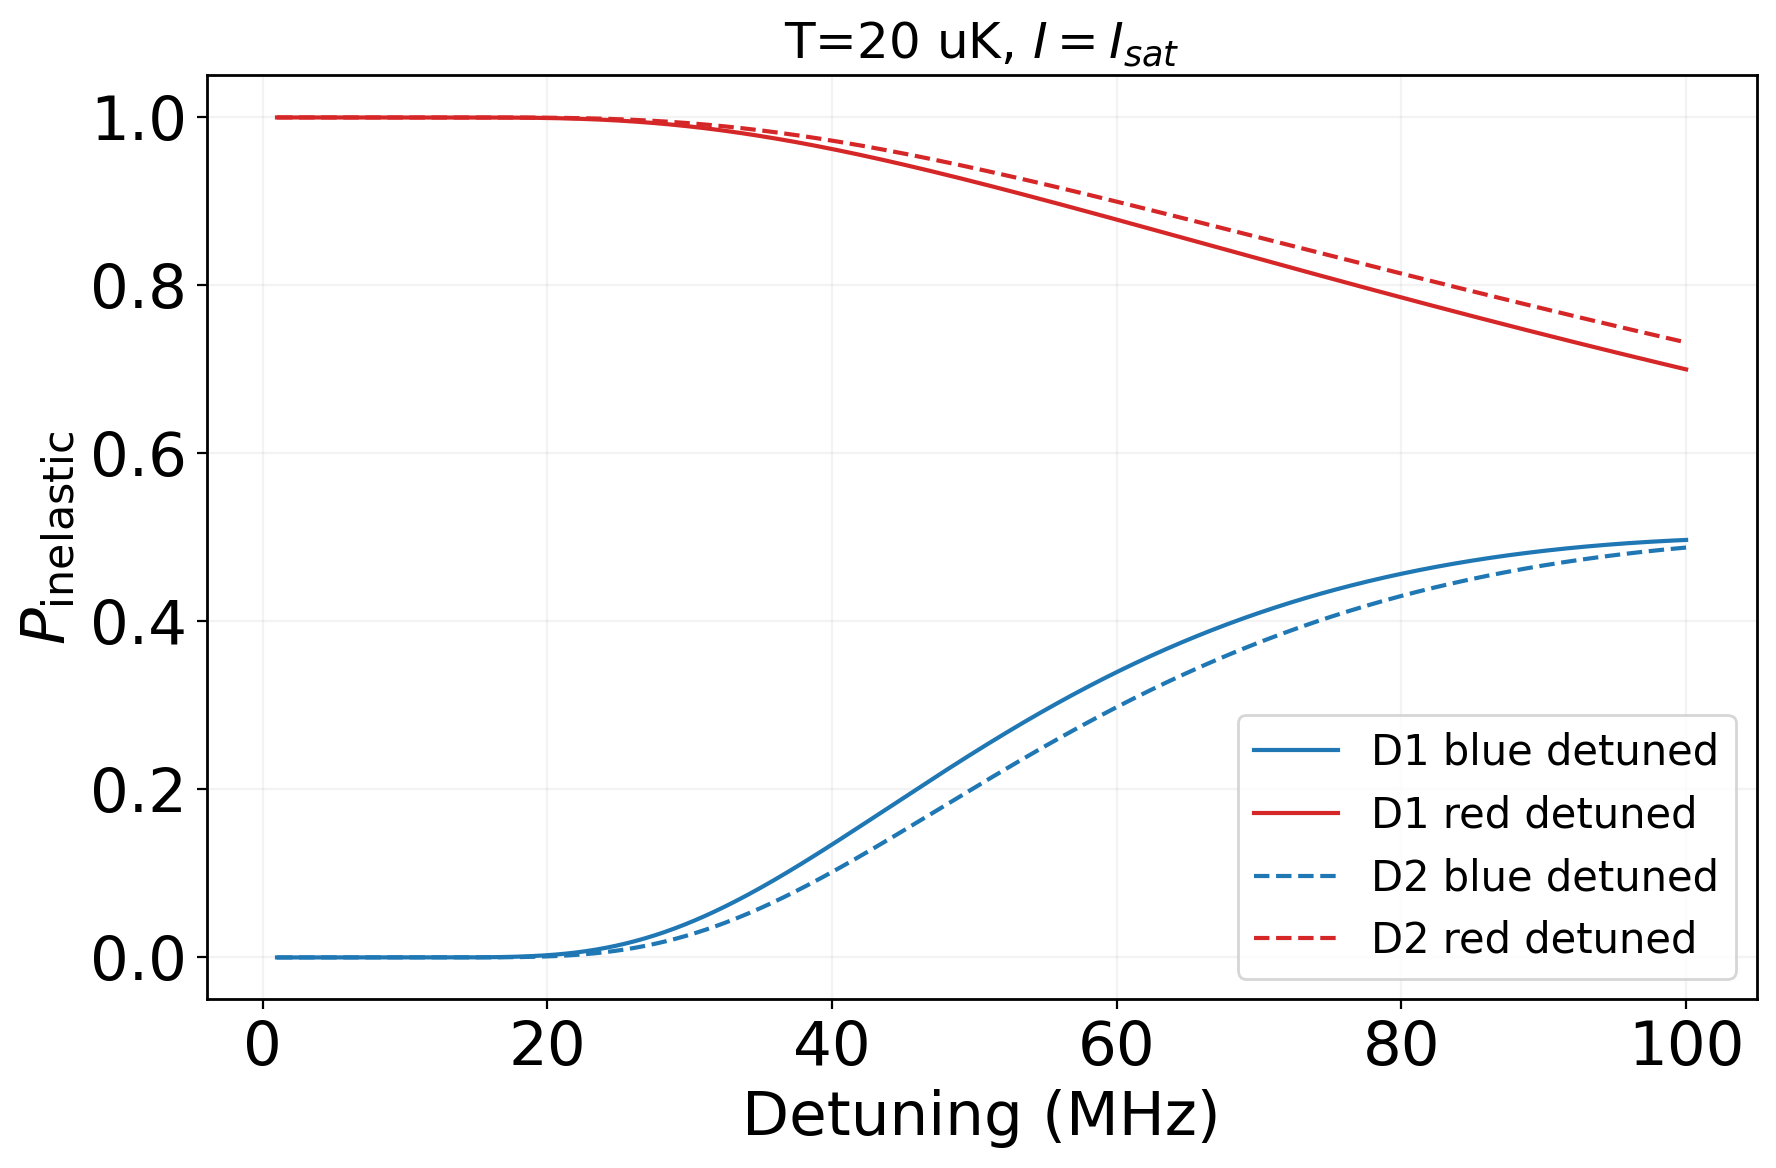

In [55]:
delta = np.linspace(1,100,1000)
T = 20e-6
IsatD1 = 4.484/5
IsatD2 = 2.503/5
muD1=2.537e-29
muD2=3.584e-29

fig, ax = plt.subplots(figsize=(10, 6))
font = {'family' : 'DejaVu Sans',
        'weight' : 'normal',
        'size'   : 22}
matplotlib.rc('font', **font)
ax.plot(delta,P_inelastic_blue(T,IsatD1,muD1,delta), color = 'tab:blue',label = 'D1 blue detuned')
ax.plot(delta,P_inelastic_red(T,IsatD1,muD1,delta), color = 'tab:red',label = 'D1 red detuned')
ax.plot(delta,P_inelastic_blue(T,IsatD2,muD2,delta),linestyle = '--', color = 'tab:blue',label = 'D2 blue detuned')
ax.plot(delta,P_inelastic_red(T,IsatD2,muD2,delta),linestyle = '--', color = 'tab:red',label = 'D2 red detuned')
plt.xlabel('Detuning (MHz)')
plt.ylabel(r'$P_{\mathrm{inelastic}}$');
plt.title('T=20 uK, $I=I_{sat}$',fontsize=18)
plt.legend(fontsize=15)

### Inelastic Prob vs temperature

Text(0.5, 1.0, '$\\Delta = 100$ MHz, $I=I_{sat}$')

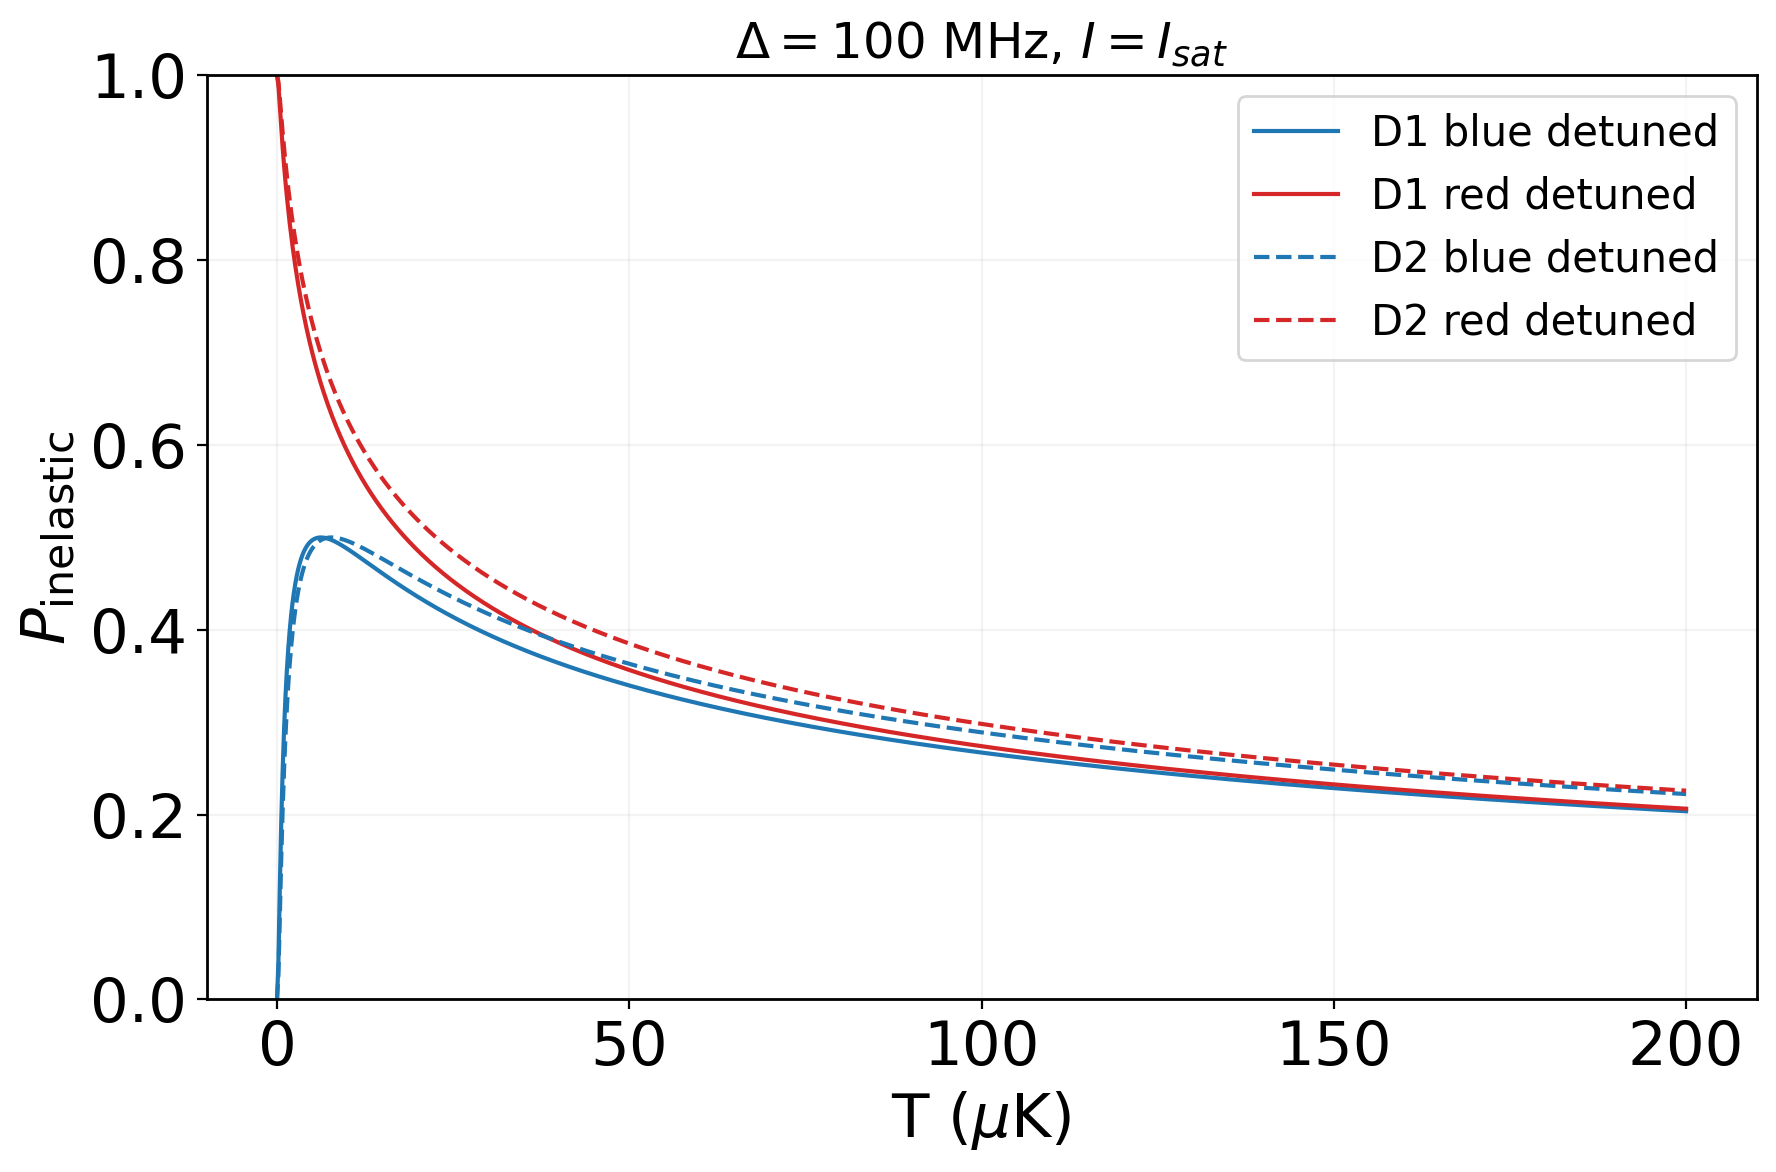

In [47]:
delta = 100
T=np.linspace(1e-30,200e-6,1000)
IsatD1 = 4.484/10
IsatD2 = 2.503/10
muD1=2.537e-29
muD2=3.584e-29

fig, ax = plt.subplots(figsize=(10, 6))
font = {'family' : 'DejaVu Sans',
        'weight' : 'normal',
        'size'   : 22}
matplotlib.rc('font', **font)
ax.plot(T*1e6,P_inelastic_blue(T,IsatD1,muD1,delta), color = 'tab:blue',label = 'D1 blue detuned')
ax.plot(T*1e6,P_inelastic_red(T,IsatD1,muD1,delta), color = 'tab:red',label = 'D1 red detuned')
ax.plot(T*1e6,P_inelastic_blue(T,IsatD2,muD2,delta),linestyle = '--', color = 'tab:blue',label = 'D2 blue detuned')
ax.plot(T*1e6,P_inelastic_red(T,IsatD2,muD2,delta),linestyle = '--', color = 'tab:red',label = 'D2 red detuned')
plt.xlabel(r'T ($\mu$K)')
plt.ylabel(r'$P_{\mathrm{inelastic}}$');
plt.ylim(0,1)
plt.legend(fontsize=15)
plt.title(r'$\Delta = 100$ MHz, $I=I_{sat}$',fontsize=18)

### Inelastic Prob vs intensity

Text(0.5, 1.0, '$\\Delta = 100$ MHz, $T=20 \\ \\mu K$')

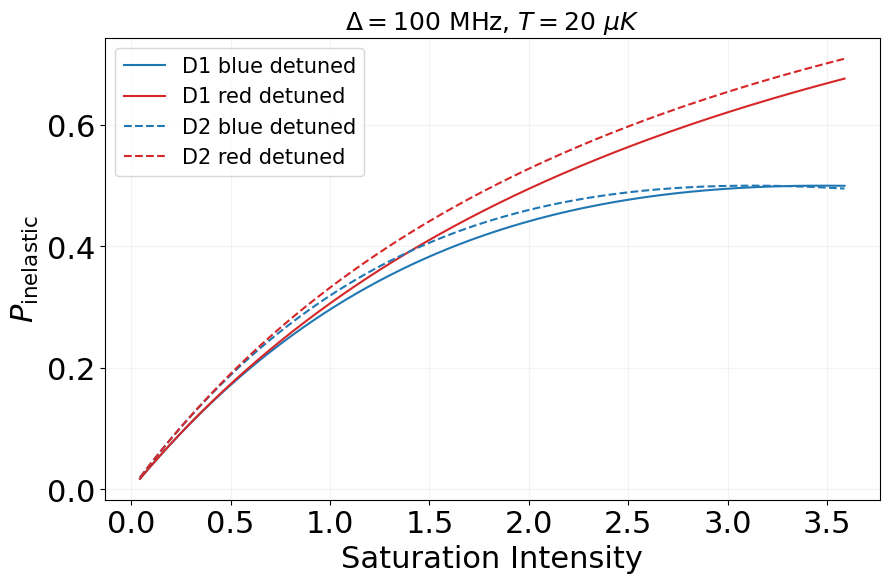

In [250]:
delta = 300
T=20e-6
IsatD1 = 4.484/10
IsatD2 = 2.503/10
ID1 = np.linspace(.1*IsatD1,8*IsatD1,1000)
ID2 = np.linspace(.1*IsatD2,8*IsatD2,1000)
muD1=2.537e-29
muD2=3.584e-29

fig, ax = plt.subplots(figsize=(10, 6))
font = {'family' : 'DejaVu Sans',
        'weight' : 'normal',
        'size'   : 22}
matplotlib.rc('font', **font)
ax.plot(ID1,P_inelastic_blue(T,ID1,muD1,delta), color = 'tab:blue',label = 'D1 blue detuned')
ax.plot(ID1,P_inelastic_red(T,ID1,muD1,delta), color = 'tab:red',label = 'D1 red detuned')
ax.plot(ID1,P_inelastic_blue(T,ID2,muD2,delta),linestyle = '--', color = 'tab:blue',label = 'D2 blue detuned')
ax.plot(ID1,P_inelastic_red(T,ID2,muD2,delta),linestyle = '--', color = 'tab:red',label = 'D2 red detuned')
plt.xlabel(r'Saturation Intensity')
plt.ylabel(r'$P_{\mathrm{inelastic}}$');
plt.legend(fontsize=15)
plt.title(r'$\Delta = 100$ MHz, $T=20 \ \mu K$',fontsize=18)

In [8]:
v1=6.1
v2 =27.6
p1=2/v1*(1-1/v1)
p2=2/v2*(1-1/v2)

print(p1/p2)
print(p1)
print(p2)

3.9250666305645874
0.2741198602526203
0.06983826927116152


## Monte Carlo - two atoms in a tweezer

In [20]:
import numpy as np
import matplotlib.pyplot as plt

# Constants
mass = mc.Rb87_M  # Mass of the atoms 
radial_frequency = 35e3  # Radial trap frequency in Hz
axial_frequency = 25e3   # Axial trap frequency in Hz

# Calculate trap stiffness constants
k_radial = mass * (2 * np.pi * radial_frequency)**2
k_axial = mass * (2 * np.pi * axial_frequency)**2

dt = 1e-6  # Time step (1 μs)
total_time = 0.01  # Total simulation time (10 ms)

# Parameters for distance check
distance_threshold = 1e-6  # Threshold for atoms coming within 100 nm

# Function to calculate the force on an atom due to the optical trap
def calculate_force(x, y, z):
    force_x = -k_radial * x
    force_y = -k_radial * y
    force_z = -k_axial * z
    return np.array([force_x, force_y, force_z])

# Function to calculate the distance between two atoms
def calculate_distance(x1, y1, z1, x2, y2, z2):
    return np.sqrt((x1 - x2)**2 + (y1 - y2)**2 + (z1 - z2)**2)

# Monte Carlo simulation parameters
num_simulations = 100
count_within_threshold = 0

for _ in range(num_simulations):
    # Initial conditions for atom 1
    x1, y1, z1 = 0.0, 0.0, 0.0
    vx1, vy1, vz1 = np.random.uniform(-0.1, 0.1, 3)

    # Initial conditions for atom 2
    x2, y2, z2 = 1.0, 0.0, 0.0
    vx2, vy2, vz2 = np.random.uniform(-0.1, 0.1, 3)

    # Perform the simulation
    current_time = 0
    within_threshold = False

    while current_time <= total_time:
        # Calculate forces on both atoms
        force1 = calculate_force(x1, y1, z1)
        force2 = calculate_force(x2, y2, z2)

        # Update positions and velocities using the leapfrog integration method
        x1 += vx1 * dt + 0.5 * (force1[0] / mass) * dt**2
        y1 += vy1 * dt + 0.5 * (force1[1] / mass) * dt**2
        z1 += vz1 * dt + 0.5 * (force1[2] / mass) * dt**2

        x2 += vx2 * dt + 0.5 * (force2[0] / mass) * dt**2
        y2 += vy2 * dt + 0.5 * (force2[1] / mass) * dt**2
        z2 += vz2 * dt + 0.5 * (force2[2] / mass) * dt**2

        # Check the distance between the atoms
        distance = calculate_distance(x1, y1, z1, x2, y2, z2)
        if distance < distance_threshold:
            within_threshold = True
            break

        # Update velocities
        vx1 += (force1[0] / mass) * dt
        vy1 += (force1[1] / mass) * dt
        vz1 += (force1[2] / mass) * dt

        vx2 += (force2[0] / mass) * dt
        vy2 += (force2[1] / mass) * dt
        vz2 += (force2[2] / mass) * dt

        # Update time
        current_time += dt

    if within_threshold:
        count_within_threshold += 1

# Calculate the probability of atoms coming within 100 nm
probability_within_threshold = count_within_threshold / num_simulations

print(f"Probability of atoms coming within 100 nm: {probability_within_threshold}")

# Create a 3D plot to visualize the last simulation
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot([x1], [y1], [z1], 'ro', label='Atom 1')
ax.plot([x2], [y2], [z2], 'bo', label='Atom 2')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.legend()
plt.title('Final Positions of Two Atoms in a 3D Optical Dipole Trap')
plt.show()


TypeError: expected a sequence of integers or a single integer, got '3e-06'

Probability of atoms coming within 100 nm: 1.0


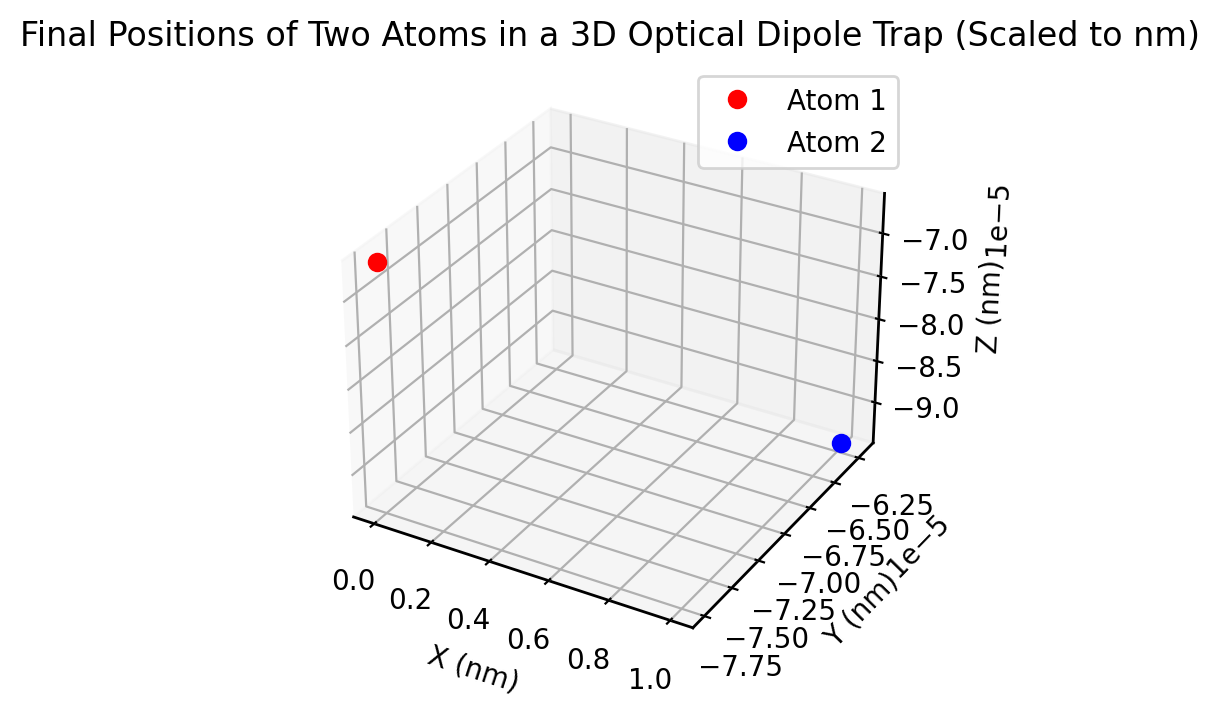

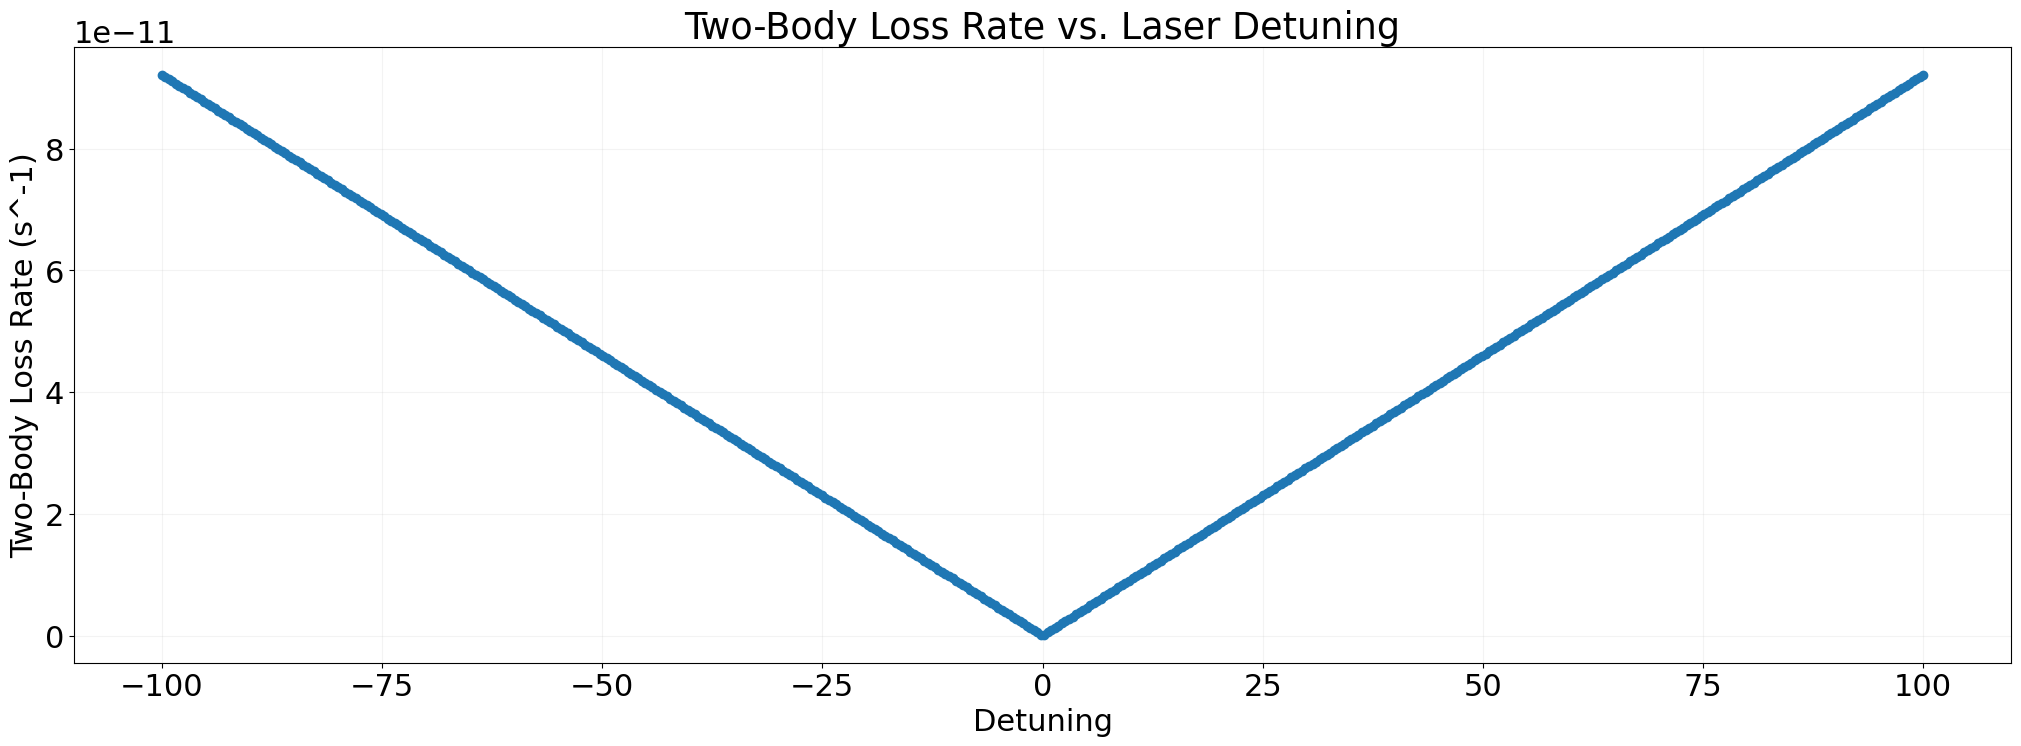

In [262]:
import numpy as np
import matplotlib.pyplot as plt

# Constants
mass = 1.0      # Mass of the trapped atom (arbitrary units)
trap_depth = 1.0  # Trap depth in arbitrary units
cross_section = 1e-11  # Collision cross-section in nm^2
dt = 1e-6      # Time step in seconds (1 μs)
total_time = 1.0  # Total simulation time in seconds

# Parameters for collision check
collision_threshold = 1e-7  # Threshold for atoms coming within 1 nm

# Function to calculate the rate of light-assisted collisions
def calculate_collision_rate(trap_depth, cross_section, temperature, detuning):
    return np.sqrt(8 * trap_depth / (np.pi * mass * temperature)) * cross_section * detuning

# Monte Carlo simulation parameters
num_simulations = 100

# Detuning values to be considered
detuning_values = np.linspace(-100, 100, 500)  # Vary detuning from -10 to 10

# Initialize arrays to store results
loss_rates = []

# Perform the Monte Carlo simulations for each detuning value
for detuning in detuning_values:
    collision_count = 0

    for _ in range(num_simulations):
        # Initial conditions for atom
        position = 0.0
        velocity = np.random.uniform(0, 0.1)  # Random initial velocity

        # Perform the simulation
        current_time = 0
        collided = False

        while current_time <= total_time:
            # Update position using the current velocity
            position += velocity * dt

            # Check for a collision event
            if np.abs(position) < collision_threshold:
                collided = True
                break

            # Update time
            current_time += dt

        if collided:
            collision_count += 1

    # Calculate the collision rate for the current detuning
    temperature = 300  # Assume a temperature of 300 K
    collision_rate = calculate_collision_rate(trap_depth, cross_section, temperature, detuning)

    # Calculate the two-body loss rate for the current detuning
    loss_rate = abs(collision_rate * collision_count / num_simulations)
    loss_rates.append(loss_rate)

# Create a plot of the two-body loss rate as a function of detuning
plt.plot(detuning_values, loss_rates, marker='o')
plt.xlabel('Detuning')
plt.ylabel('Two-Body Loss Rate (s^-1)')
plt.title('Two-Body Loss Rate vs. Laser Detuning')
plt.grid(True)
plt.show()


## rabi rate vs intensity

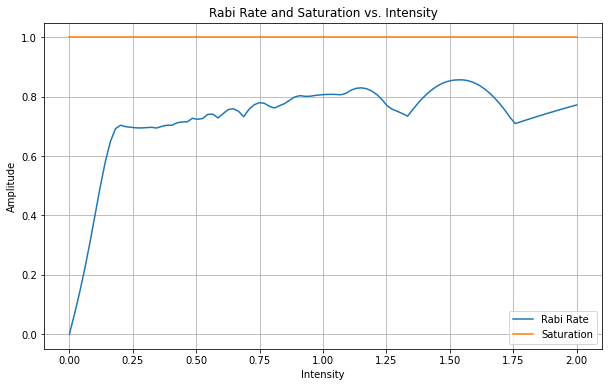

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from qutip import *
from scipy.constants import e, hbar

# Define constants
omega_0 = 1.0  # Transition frequency
gamma = 0.1   # Spontaneous decay rate
t_list = np.linspace(0, 20, 500)  # Time values
intensity_list = np.linspace(0, 2, 100)  # Intensity values

# Create lists to store Rabi rates and saturation values
rabi_rates = []
saturation_values = []

# Perform simulations for different intensities
for intensity in intensity_list:
    omega = 2 * np.pi * omega_0  # Angular frequency for this intensity
    H0 = 0.5 * omega * sigmaz()
    H1 = intensity * sigmax()
    
    H = [H0, [H1, f'sin({omega}*t)']]  # Time-dependent Hamiltonian using f-string
    
    result = mesolve(H, basis(2, 0), t_list, [np.sqrt(gamma) * sigmam()], [sigmax(), sigmay(), sigmaz()])
    
    # Calculate Rabi rate as the amplitude of the oscillations
    rabi_amplitude = max(result.expect[0])  # Assuming Rabi oscillates in the X direction
    
    # Calculate saturation (probability of being in the excited state)
    saturation = max(result.expect[2])
    
    rabi_rates.append(rabi_amplitude)
    saturation_values.append(saturation)

# Plot Rabi rate as a function of intensity with saturation
plt.figure(figsize=(10, 6))
plt.plot(intensity_list, rabi_rates, label='Rabi Rate')
plt.plot(intensity_list, saturation_values, label='Saturation')
plt.xlabel('Intensity')
plt.ylabel('Amplitude')
plt.legend()
plt.title('Rabi Rate and Saturation vs. Intensity')
plt.grid(True)
plt.show()
